In [582]:
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import torch
from collections import OrderedDict
from typing import List, Tuple
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
import flwr as fl
from flwr.common import Metrics
import random
import torch.nn as nn
from typing import Union, Optional
DEVICE = torch.device("mps")

In [73]:
consumers = [i for i in range(1, 51)]
training_consumers = random.sample(consumers, int(0.8*len(consumers)))
test_consumers = [i for i in consumers if i not in training_consumers]

In [72]:
test_consumers

[6, 7, 17, 20, 22, 27, 28, 31, 41, 47]

In [159]:
class RegressionData(Dataset):
    def __init__(self, path):
        df = pd.read_csv(path)
        self.x = df['appliances'].values
    
    def __len__(self):
        return (len(self.x) // 96) - 8
    
    def __getitem__(self, idx):
        if idx > 358:
            raise Exception('Unbounded window')
        return torch.tensor(self.x[idx*96:(idx+7)*(96)], dtype=torch.float32), torch.tensor(self.x[(idx+7)*96:(idx+8)*96], dtype=torch.float32)

In [160]:
dataset = RegressionData(f'./data/Consumer2.csv')

In [573]:
class MyRNN(nn.Module):
    def __init__(self, hid_size):
        super(MyRNN, self).__init__()
        self.hidden_size = hid_size
        self.rnn = nn.LSTM(input_size=1, hidden_size=self.hidden_size, num_layers=2)
        self.fc1 = nn.Linear(self.hidden_size, 1)

    def forward(self, inputs, hidden_state, cell):
        outputs = []
        inputs = inputs.view(-1, 1)
        output, (hidden_states, cell) = self.rnn(inputs, (hidden_state, cell))
        output = nn.functional.relu(self.fc1(output))
        return output, hidden_states, cell

In [574]:
len(dataset)

358

In [578]:
from tqdm import tqdm

In [592]:
def train(net, dataset):
    """Train the network on the training set."""
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.AdamW(net.parameters(), lr=3e-5)
    net.train()
    val_losses = []
    for i in tqdm(range(10)):
        for i in range(len(dataset)):
            x, Y = dataset[i]
            Y = Y.to(DEVICE)
            x = x.to(DEVICE)
            hidden = torch.zeros((2, net.hidden_size)).to(DEVICE)
            cell = torch.zeros((2, net.hidden_size)).to(DEVICE)
            
            outs, hidden, cell = net(x, hidden, cell)
            output, _, _ = net(Y, hidden, cell)
            z = torch.cat([outs[-1], output[:-1].squeeze()])
            loss = criterion(Y, z)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            val_losses.append(loss.item())    
    return val_losses

In [593]:
model = MyRNN(256).to(DEVICE)

In [594]:
losses = train(model, RegressionData(f'./data/Consumer2.csv'))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:44<00:00, 28.41s/it]


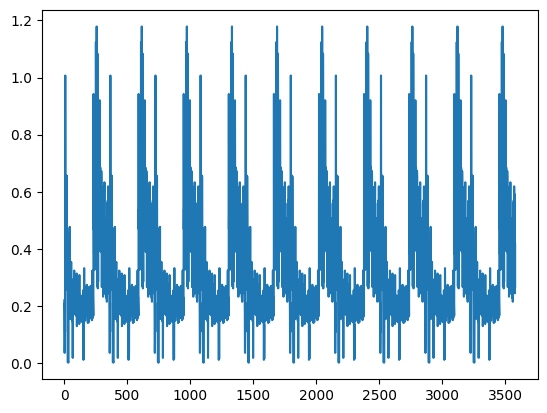

In [595]:
plt.plot(losses)

In [541]:
def test(net, dataset):
    """Train the network on the training set."""
    criterion = torch.nn.MSELoss()
    net.eval()
    val_losses = []
    outputs = []
    with torch.no_grad():
        for i in range(len(dataset)):
            x, Y = dataset[i]
            hidden_state = torch.zeros((2, net.hidden_size))
            out, hidden = net(x, hidden_state)
            z = [out[-1].squeeze().item()]
            for _ in range(95):
                o, h = net(torch.tensor(z[-1]), hidden)
                z.append(o.item())
            loss = criterion(Y, torch.tensor(z))
            val_losses.append(loss.item())
            outputs += z
    return val_losses, outputs

In [542]:
loss, outs = test(model, eval_dataset)

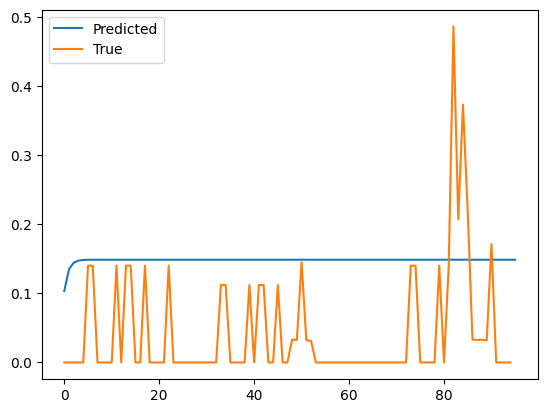

In [543]:
plt.plot(outs[:96], label='Predicted')
plt.plot(eval_dataset[0][1][:95], label='True')
plt.legend()
plt.show()

In [405]:
sum([p.numel() for p in model.parameters()])

46

In [377]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

In [378]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, dataset):
        self.net = net
        self.dataset = dataset
        self.losses = []

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        loss = train(self.net, self.dataset)
        self.losses = loss
        return get_parameters(self.net), len(self.dataset), {'loss': loss}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        return 0.0, 1, {}


In [379]:
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""
    # Load model
    cid = int(cid) + 1
    net = MyRNN(hid_size=100).to(DEVICE)
    dataset = RegressionData(f'./data/Consumer{cid}.csv')

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, dataset)


In [380]:
class SaveModelStrategy(fl.server.strategy.FedAvg):
    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[fl.server.client_proxy.ClientProxy, fl.common.FitRes]],
        failures: List[Union[Tuple[fl.server.client_proxy.ClientProxy, fl.common.FitRes], BaseException]],
    ):
        """Aggregate model weights using weighted average and store checkpoint"""
        net = MyRNN(hid_size=100).to(DEVICE)

        # Call aggregate_fit from base class (FedAvg) to aggregate parameters and metrics
        aggregated_parameters, aggregated_metrics = super().aggregate_fit(server_round, results, failures)

        if aggregated_parameters is not None:
            print(f"Saving round {server_round} aggregated_parameters...")

            # Convert `Parameters` to `List[np.ndarray]`
            aggregated_ndarrays: List[np.ndarray] = fl.common.parameters_to_ndarrays(aggregated_parameters)

            # Convert `List[np.ndarray]` to PyTorch`state_dict`
            params_dict = zip(net.state_dict().keys(), aggregated_ndarrays)
            state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
            net.load_state_dict(state_dict, strict=True)

            # Save the model
            torch.save(net.state_dict(), f"model_round_{server_round}.pth")

        return aggregated_parameters, aggregated_metrics

In [381]:
# Create FedAvg strategy
strategy = SaveModelStrategy(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=40,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=40,  # Wait until all 10 clients are available
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=40,
    config=fl.server.ServerConfig(num_rounds=3),
    strategy=strategy,
    client_resources=client_resources,
)


INFO flwr 2023-10-31 09:29:25,374 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=3, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=3, round_timeout=None)
Exception in thread Thread-68:
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.10/3.10.13/Frameworks/Python.framework/Versions/3.10/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/opt/homebrew/Cellar/python@3.10/3.10.13/Frameworks/Python.framework/Versions/3.10/lib/python3.10/threading.py", line 1378, in run
    self.function(*self.args, **self.kwargs)
  File "/opt/homebrew/lib/python3.10/site-packages/flwr/simulation/app.py", line 258, in update_resources
    num_max_actors = pool_size_from_resources(client_resources)
  File "/opt/homebrew/lib/python3.10/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 107, in pool_size_from_resources
    nodes = ray.nodes()
  File "/opt/homebrew/lib/pyth

Saving round 1 aggregated_parameters...


DEBUG flwr 2023-10-31 09:30:58,152 | server.py:236 | fit_round 2 received 40 results and 0 failures
DEBUG:flwr:fit_round 2 received 40 results and 0 failures
DEBUG flwr 2023-10-31 09:30:58,171 | server.py:173 | evaluate_round 2: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 2: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 09:30:58,283 | server.py:187 | evaluate_round 2 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 20 results and 0 failures
DEBUG flwr 2023-10-31 09:30:58,283 | server.py:222 | fit_round 3: strategy sampled 40 clients (out of 40)
DEBUG:flwr:fit_round 3: strategy sampled 40 clients (out of 40)


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-10-31 09:31:42,168 | server.py:236 | fit_round 3 received 40 results and 0 failures
DEBUG:flwr:fit_round 3 received 40 results and 0 failures
DEBUG flwr 2023-10-31 09:31:42,187 | server.py:173 | evaluate_round 3: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 3: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 09:31:42,300 | server.py:187 | evaluate_round 3 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 20 results and 0 failures
INFO flwr 2023-10-31 09:31:42,301 | server.py:153 | FL finished in 132.12482887500664
INFO:flwr:FL finished in 132.12482887500664
INFO flwr 2023-10-31 09:31:42,301 | app.py:225 | app_fit: losses_distributed [(1, 0.0), (2, 0.0), (3, 0.0)]
INFO:flwr:app_fit: losses_distributed [(1, 0.0), (2, 0.0), (3, 0.0)]
INFO flwr 2023-10-31 09:31:42,302 | app.py:226 | app_fit: metrics_distributed_fit {}
INFO:flwr:app_fit: metrics_distributed_fit {}
INFO flwr 2023-10-31 09:31:42,302 | app.py:227 | app_fit

Saving round 3 aggregated_parameters...


History (loss, distributed):
	round 1: 0.0
	round 2: 0.0
	round 3: 0.0

In [382]:
net = MyRNN(hid_size=100)
net.load_state_dict(torch.load('./model_round_3.pth'), strict=True)

<All keys matched successfully>

In [391]:
eval_dataset = RegressionData(f'./data/Consumer44.csv')

In [392]:
loss, outs = test(net, eval_dataset)

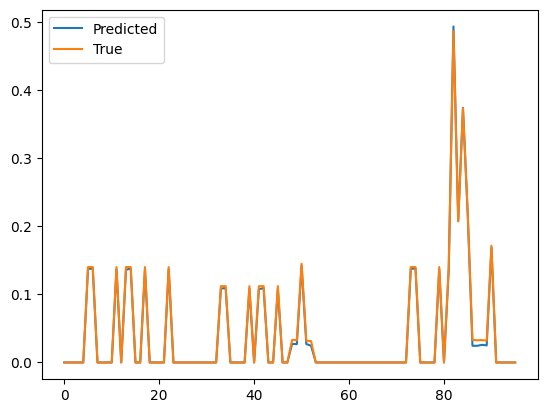

In [393]:
plt.plot(outs[:96], label='Predicted')
plt.plot(eval_dataset[0][1][:96], label='True')
plt.legend()
plt.show()